In [1]:
# Cell 1: Import and define the solver function
import torch

In [25]:
# Check for CUDA availability and set the device
PRECISION = torch.float16
# Set the precision for A and B
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")


def optimized_linear_system_solver(A, B):
    N = A.shape[0]
    tile_size = 16
    num_tiles = N // tile_size

    # Ensure A and B are on the correct device and in the correct format
    A = A.to(DEVICE).to(PRECISION)
    B = B.to(DEVICE).to(PRECISION)
    X = torch.zeros_like(B)

    for i in range(num_tiles):
        start = i * tile_size
        end = (i + 1) * tile_size

        # Extract the current 16x16 tile from A
        A_tile = A[start:end, start:end]

        # Compute N = I - A_tile
        N = torch.eye(tile_size, device=DEVICE, dtype=PRECISION) - A_tile
        plt.imshow(N.cpu().numpy())

        # Compute A_tile^(-1) * B_tile using the series expansion
        B_tile = B[start:end, :]
        X_tile = B_tile.clone()
        N_power_B = B_tile.clone()
        for j in range(
            1, tile_size
        ):  # We start from 1 as the 0th term is already in X_tile
            N_power_B = torch.matmul(N, N_power_B)
            print(f"Iteration={j}\nN_power_B: {N_power_B}")
            X_tile += N_power_B
            print(f"Iteration={j}\nX_tile: {X_tile}")

        # Store the result in X
        X[start:end, :] = X_tile

        # Update B for the next iterations
        if i < num_tiles - 1:
            B[end:, :] -= torch.matmul(A[end:, start:end], X_tile)

    return X


# Test function
def test_matrix(N):
    torch.manual_seed(0)  # For reproducibility
    A = torch.tril(
        torch.randn(N, N, device=DEVICE, dtype=PRECISION), diagonal=-1
    ) + torch.eye(N, device=DEVICE, dtype=PRECISION)
    B = torch.randn(N, 16, device=DEVICE, dtype=PRECISION)

    X = optimized_linear_system_solver(A, B)

    # Verify the result
    residual = torch.norm(torch.matmul(A, X) - B)
    print(f"Test case ({N}x{N} matrix) residual: {residual.item()}")

Using device: cpu


In [26]:
N = 8
torch.manual_seed(0)  # For reproducibility
A = torch.tril(
    torch.randn(N, N, device=DEVICE, dtype=PRECISION), diagonal=-1
) + torch.eye(N, device=DEVICE, dtype=PRECISION)
print(f"A: {A}")
B = torch.randn(N, 16, device=DEVICE, dtype=PRECISION)


X = optimized_linear_system_solver(A, B)

A: tensor([[ 1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [-0.0255,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.2206, -1.3213,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [-0.8027,  0.7852, -0.5044,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [-0.2927,  1.0859,  0.9521, -1.6553,  1.0000,  0.0000,  0.0000,  0.0000],
        [ 0.1732,  0.3403, -0.1177, -1.0010,  2.7363,  1.0000,  0.0000,  0.0000],
        [-0.1031, -0.3955,  1.0488,  2.3613, -0.6748,  0.0058,  1.0000,  0.0000],
        [ 1.0791,  0.5532,  0.9736,  1.1797,  1.2373,  0.9121, -0.8535,  1.0000]],
       dtype=torch.float16)


In [29]:
# Unrelated: A is a square matrix of 1,2,3, 4, ... N
# B is another square matrix of random integers

N = 16
A = torch.tensor([[i + j for i in range(N)] for j in range(N)], device=DEVICE, dtype=PRECISION)
B = torch.randint(0, 10, (N, N), device=DEVICE, dtype=PRECISION)

print(f"A: {A}")
print(f"B: {B}")

# multiply A and B and keep the first two columns
res_1 = torch.matmul(A, B)[:, :2]

res_2 = torch.matmul(A, B[:, :2])

assert torch.allclose(res_1, res_2)

print(f"res_1: {res_1}")
print(f"res_2: {res_2}")


A: tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
         14., 15.],
        [ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14.,
         15., 16.],
        [ 2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15.,
         16., 17.],
        [ 3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15., 16.,
         17., 18.],
        [ 4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15., 16., 17.,
         18., 19.],
        [ 5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15., 16., 17., 18.,
         19., 20.],
        [ 6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15., 16., 17., 18., 19.,
         20., 21.],
        [ 7.,  8.,  9., 10., 11., 12., 13., 14., 15., 16., 17., 18., 19., 20.,
         21., 22.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15., 16., 17., 18., 19., 20., 21.,
         22., 23.],
        [ 9., 10., 11., 12., 13., 14., 15., 16., 17., 18., 19., 20., 21., 22.,
         23., 24.],
       

In [23]:
import matplotlib.pyplot as plt

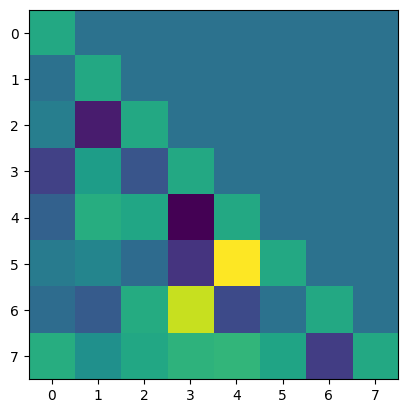

In [24]:
plt.imshow(A)

In [17]:
# Cell 3: Run tests
# Test case 1: Small matrix (32x32)
test_matrix(32)

# # Cell 4: Run tests
# # Test case 2: Medium matrix (256x256)
# test_matrix(256)

# # Cell 5: Run tests
# # Test case 3: Large matrix (1024x1024)
# test_matrix(1024)

Iteration=1
N_power_B: tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [ 3.1616e-02,  1.0950e-01,  1.8518e-01, -9.8267e-02, -4.8248e-02,
          1.6406e-01,  8.8989e-02,  5.2490e-01,  2.6123e-02, -2.3987e-01,
         -1.6919e-01, -3.7262e-02,  4.7559e-01,  8.1970e-02, -3.3234e-02,
         -2.0801e-01],
        [-9.0714e-03, -6.7871e-02, -1.0065e-01,  4.6234e-02,  3.7170e-02,
         -9.5032e-02, -3.8727e-02, -2.9736e-01, -1.5268e-03,  1.0419e-01,
          8.3618e-02,  6.6643e-03, -2.2510e-01, -2.8854e-02,  1.1566e-02,
          8.8257e-02],
        [ 2.2266e+00,  5.9912e-01,  1.8740e+00, -5.0830e-01, -1.2295e+00,
         -6.5247e-02,  9.5520e-02, -1.8770e+00,  2.2441e+00,  1.5244e-02,
         -1.8027e+00,  7.9639e-01,  3.4204e-01,  1.5674e+00,  1.1787e+00,
         -1.1255e-01

In [18]:
import torch

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")


def optimized_linear_system_solver(A, B):
    N = A.shape[0]
    tile_size = 16
    num_tiles = N // tile_size

    # Ensure A and B are on the correct device and in the correct format
    A = A.to(DEVICE).to(torch.float32)  # Changed to float32 for better precision
    B = B.to(DEVICE).to(torch.float32)
    X = torch.zeros_like(B)

    for i in range(num_tiles):
        start = i * tile_size
        end = (i + 1) * tile_size

        # Extract the current tile from A
        A_tile = A[start:end, start:end]

        # Solve A_tile * X_tile = B_tile directly
        B_tile = B[start:end, :]
        X_tile, _ = torch.triangular_solve(B_tile, A_tile, upper=False)

        # Store the result in X
        X[start:end, :] = X_tile

        # Update B for the next iterations
        if i < num_tiles - 1:
            B[end:, :] -= torch.matmul(A[end:, start:end], X_tile)

    return X


def test_matrix(N):
    torch.manual_seed(0)  # For reproducibility
    A = torch.tril(torch.randn(N, N, device=DEVICE, dtype=torch.float32), diagonal=0)
    A = A + torch.eye(N, device=DEVICE, dtype=torch.float32)  # Ensure A is invertible
    B = torch.randn(N, 16, device=DEVICE, dtype=torch.float32)

    X = optimized_linear_system_solver(A, B)

    # Verify the result
    residual = torch.norm(torch.matmul(A, X) - B) / torch.norm(B)
    print(f"Test case ({N}x{N} matrix) relative residual: {residual.item()}")

    # Compare with torch.linalg.solve
    X_torch = torch.linalg.solve(A, B)
    residual_torch = torch.norm(torch.matmul(A, X_torch) - B) / torch.norm(B)
    print(
        f"torch.linalg.solve ({N}x{N} matrix) relative residual: {residual_torch.item()}"
    )


Using device: cpu


In [19]:
test_matrix(32)
test_matrix(256)
test_matrix(1024)

Test case (32x32 matrix) relative residual: 0.9999998211860657
torch.linalg.solve (32x32 matrix) relative residual: 3.540858415362891e-06
Test case (256x256 matrix) relative residual: nan
torch.linalg.solve (256x256 matrix) relative residual: nan
Test case (1024x1024 matrix) relative residual: nan
torch.linalg.solve (1024x1024 matrix) relative residual: nan


/var/folders/xs/19x2cmc95hz0kl_cxbgd4bnh0000gn/T/ipykernel_13897/3890714044.py:26: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:2198.)
  X_tile, _ = torch.triangular_solve(B_tile, A_tile, upper=False)
